In [112]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat, periodic_cumsum
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt
from scipy import signal

%matplotlib inline
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(20200305)

In [113]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


torch.Size([78888, 1])


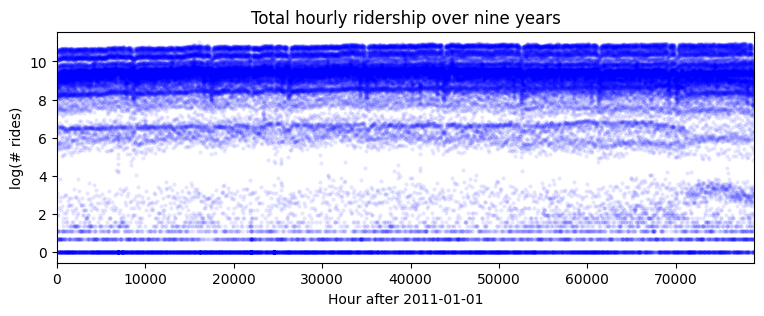

In [114]:
data = dataset["counts"].sum([-1, -2]).unsqueeze(-1).log1p()
print(data.shape)
plt.figure(figsize=(9, 3))
plt.plot(data, 'b.', alpha=0.1, markeredgewidth=0)
plt.title("Total hourly ridership over nine years")
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(0, len(data));

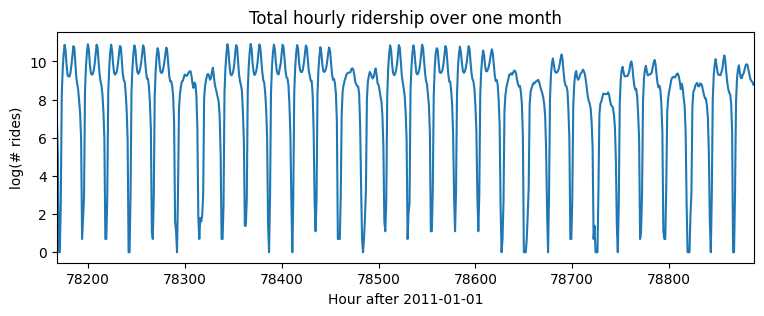

In [115]:
plt.figure(figsize=(9, 3))
plt.plot(data)
plt.title("Total hourly ridership over one month")
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(len(data) - 24 * 30, len(data));

### GaussianHMM

torch.Size([10000, 2])
torch.Size([1000, 2])


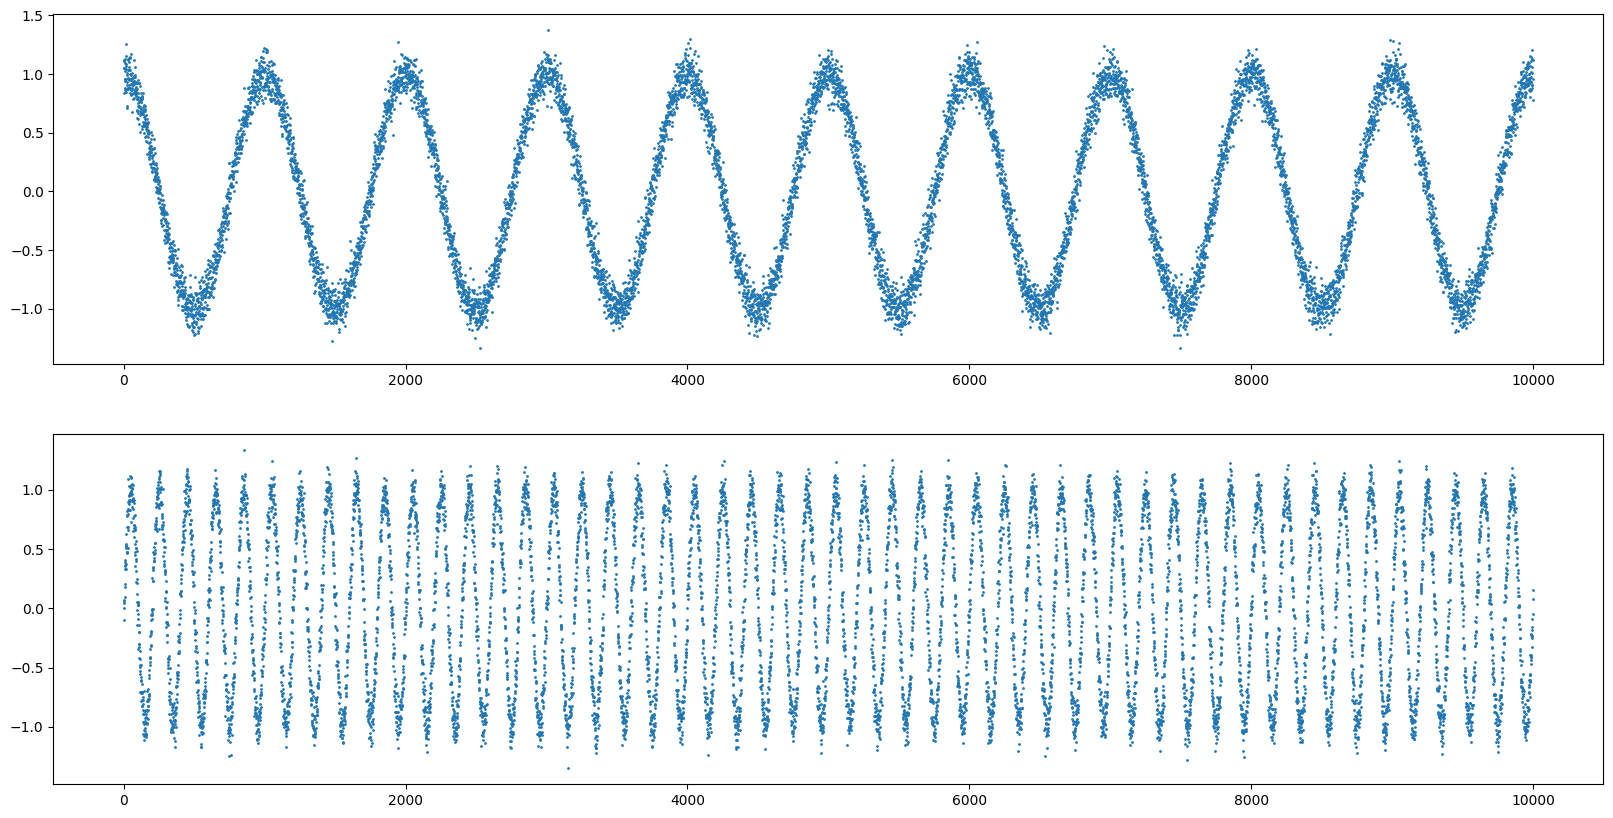

In [127]:
# timeTest=torch.linspace(0,2*math.pi*(100),100*100) 
# dataTest_no_noise=torch.sin(0.2*timeTest).unsqueeze(-1) # 20 cycles each of 500 points and let dimensions be [10000,1]
# dataTest=dataTest_no_noise+torch.randn(dataTest_no_noise.shape)*0.2
# dataTest2D = dataTest.tile((2,))
timeTest=torch.linspace(0,2*math.pi*(100),100*100).unsqueeze(-1)
timeTest2D = timeTest.tile((2,))*torch.tensor([0.1,0.5])+torch.tensor([math.pi/2,0])
dataTest2D_clean=torch.sin(timeTest2D)
dataTest2D=dataTest2D_clean+torch.randn(dataTest2D_clean.shape)*0.1
print(dataTest2D.shape)

T0_test = 0
T2_test = dataTest2D.size(-2)
T1_test = T2_test-1000 # predict last two cycles

fig,ax=plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(torch.arange(T0_test,T2_test),dataTest2D[:,0],s=1)
ax[1].scatter(torch.arange(T0_test,T2_test),dataTest2D[:,1],s=1)




meansTest=dataTest2D[:int(100/0.1),:] # use first cycle as periodic repeat, should only be [500], not [500,1]

print(meansTest.shape)


In [117]:
class Model1(ForecastingModel):
    def model(self, zero_data, covariates):
        period=1000
        duration, dim = zero_data.shape[-2:]

        # Sample global parameters.
        # noise_scale = pyro.sample(
        #     "noise_scale", dist.LogNormal(torch.full((dim,), -3.0), 1.0).to_event(1)
        # )
        # assert noise_scale.shape[-1:] == (dim,)

        # Note the initial seasonality should be sampled in a plate with the
        # same dim as the time_plate, dim=-1. That way we can repeat the dim
        # below using periodic_repeat().
        with pyro.plate("season_plate", period, dim=-1):
            season_init = pyro.sample(
                "season_init", dist.Normal(torch.zeros(dim), 1).to_event(1)
            )
        assert season_init.shape[-2:] == (period, dim)

        # Sample independent noise at each time step.
        # with self.time_plate:
        #     season_noise = pyro.sample(
        #         "season_noise", dist.Normal(0, noise_scale).to_event(1)
        #     )
        #     assert season_noise.shape[-2:] == (duration, dim)

        # Construct a prediction. This prediction has an exactly repeated
        # seasonal part plus slow seasonal drift. We use two deterministic,
        # linear functions to transform our diagonal Normal noise to nontrivial
        # samples from a Gaussian process.
        prediction = periodic_repeat(season_init, duration, dim=-2) #+ periodic_cumsum(
        #   season_noise, period, dim=-2
        #)
        assert prediction.shape[-2:] == (duration, dim)

        # We'll hard-code the periodic part of this model, learning only the local model.
        #prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)
        #prediction = periodic_repeat(meansTest, duration, dim=-2)

        # On top of this mean prediction, we'll learn a linear dynamical system.
        # This requires specifying five pieces of data, on which we will put structured priors.
    

        trans_timescale = pyro.sample(
            "trans_timescale", dist.LogNormal(torch.zeros(dim), 1).to_event(1)
        )
        assert trans_timescale.shape[-1:] == (dim,)

        trans_loc = pyro.sample("trans_loc", dist.Cauchy(0, 1 / period))
        trans_loc = trans_loc.unsqueeze(-1).expand(trans_loc.shape + (dim,))
        assert trans_loc.shape[-1:] == (dim,)
        trans_scale = pyro.sample(
            "trans_scale", dist.LogNormal(torch.zeros(dim), 0.1).to_event(1)
        )
        trans_corr = pyro.sample("trans_corr", dist.LKJCholesky(dim, torch.ones(())))
        trans_scale_tril = trans_scale.unsqueeze(-1) * trans_corr
        assert trans_scale_tril.shape[-2:] == (dim, dim)

        obs_scale = pyro.sample(
            "obs_scale", dist.LogNormal(torch.zeros(dim), 0.1).to_event(1)
        )
        obs_corr = pyro.sample("obs_corr", dist.LKJCholesky(dim, torch.ones(())))
        obs_scale_tril = obs_scale.unsqueeze(-1) * obs_corr
        assert obs_scale_tril.shape[-2:] == (dim, dim)


        init_dist = dist.Normal(torch.zeros(dim), 10).to_event(1)
        trans_mat = trans_timescale.neg().exp().diag_embed()
        trans_dist = dist.MultivariateNormal(trans_loc, scale_tril=trans_scale_tril)
        obs_mat = torch.eye(dim)
        obs_dist = dist.MultivariateNormal(torch.zeros(dim), scale_tril=obs_scale_tril)
        noise_model = dist.GaussianHMM(
            init_dist, trans_mat, trans_dist, obs_mat, obs_dist, duration=duration
        )
        assert noise_model.event_shape == (duration, dim)

        noise_dist = dist.GaussianHMM(
            init_dist, trans_mat, trans_dist, obs_mat, obs_dist, duration=duration)
        self.predict(noise_dist, prediction)

In [119]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
# covariates = torch.zeros(len(data), 0)  # emptyt
covariatesTest = torch.zeros(len(dataTest2D), 0)  # empty
forecaster = Forecaster(Model1(), dataTest2D[:T1_test], covariatesTest[:T1_test], learning_rate=0.1, num_steps=400)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 1.70958
INFO 	 step  100 loss = -0.549656
INFO 	 step  200 loss = -0.605674
INFO 	 step  300 loss = -0.653319


trans_loc = -0.001326
CPU times: total: 2min 11s
Wall time: 34.4 s


torch.Size([500, 1000, 2]) torch.Size([1000, 2]) torch.Size([1000, 2])


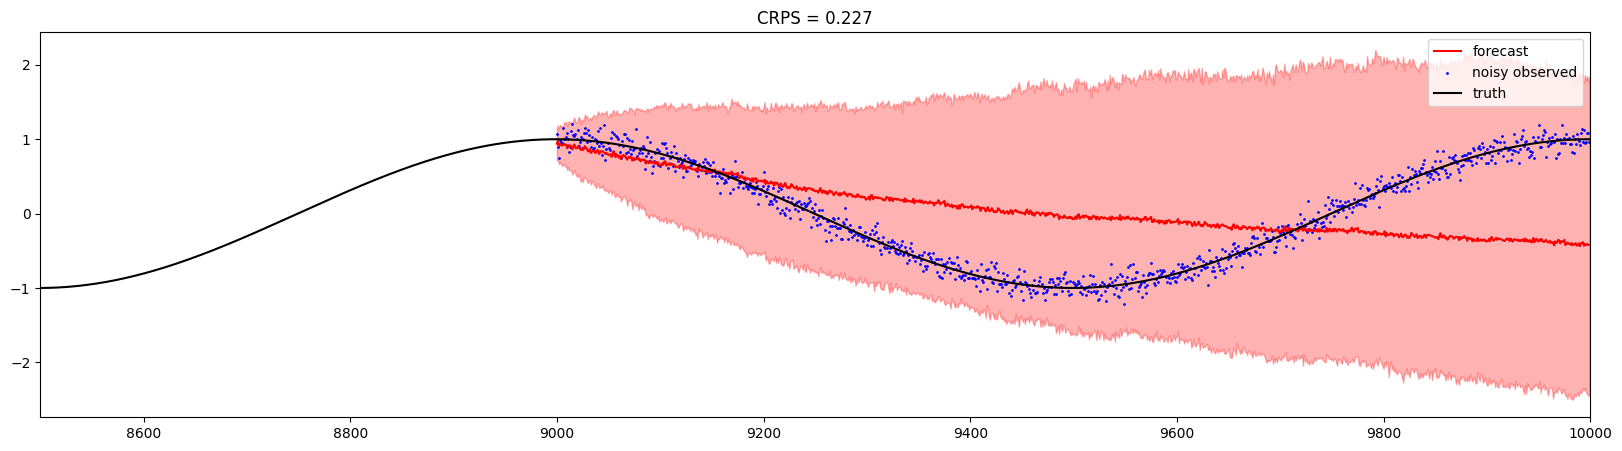

In [126]:
samples = forecaster(dataTest2D[:T1_test], covariatesTest, num_samples=500)
#samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.025, 0.5, 0.975)).squeeze(-1)
meanSamples=samples.mean(dim=0)
crps = eval_crps(samples, dataTest2D[T1_test:])
print(samples.shape, p10.shape,meanSamples.shape)


printIdx=0

plt.figure(figsize=(20, 5))
plt.fill_between(torch.arange(T1_test, T2_test), p10[:,printIdx], p90[:,printIdx], color="red", alpha=0.3)
#plt.scatter(torch.arange(T1_test, T2_test), p50[:,printIdx], s=1,c='r', label='forecast')
plt.plot(torch.arange(T1_test, T2_test), meanSamples[:,printIdx], '-r', label='forecast')
plt.scatter(torch.arange(T1_test, T2_test), dataTest2D[T1_test : T2_test,printIdx], s=1, c='b', label='noisy observed')
plt.plot(torch.arange(T1_test-(500), T2_test),
         dataTest2D_clean[T1_test-(500) : T2_test,printIdx], 'k-', label='truth')
plt.title("CRPS = {:0.3g}".format(crps))
plt.xlim(T1_test-(500), T2_test)
plt.legend(loc="best");

# plt.figure(figsize=(9, 3))
# plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
# plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
# plt.plot(torch.arange(T1 - 24 * 7, T2),
#          data[T1 - 24 * 7: T2], 'k-', label='truth')
# plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
# plt.ylabel("log(# rides)")
# plt.xlabel("Hour after 2011-01-01")
# plt.xlim(T1 - 24 * 7, T2)
# plt.text(78732, 3.5, "Christmas", rotation=90, color="green")
# plt.legend(loc="best");

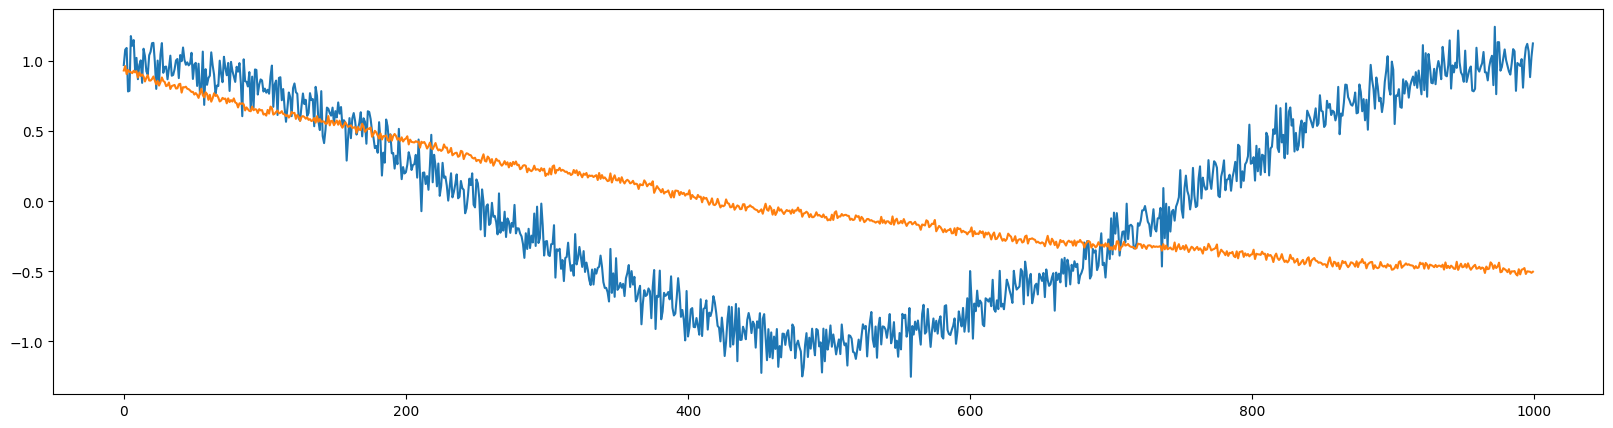

In [124]:
plt.figure(figsize=(20,5))
plt.plot(meansTest[:,0])
plt.plot(meanSamples[:,0])
